<a href="https://colab.research.google.com/github/Govind-Asawa/US_Car_Accidents/blob/master/ML_US_Car_accidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import math
import re
import random

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# READING THE CSV
df = pd.read_csv('/content/gdrive/MyDrive/CSCE - 5215 - ML Project/balanced_sample_df.csv')

**Columns we do not need:** ID, source, timezone, Description, street, country, airport_code, weather_timestamp, civil_twilight, nautical_twilight, astronomical_twilight

In [ ]:
df.columns = df.columns.map(lambda col: col.lower())

df = df.drop(
    ['id', 'source', 'timezone', 'end_lat', 'end_lng', 'description', 'street', 'country', 'airport_code', 'weather_timestamp',
     'civil_twilight', 'nautical_twilight', 'astronomical_twilight'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533514 entries, 0 to 533513
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   severity           533514 non-null  int64  
 1   start_time         533514 non-null  object 
 2   end_time           533514 non-null  object 
 3   start_lat          533514 non-null  float64
 4   start_lng          533514 non-null  float64
 5   distance(mi)       533514 non-null  float64
 6   city               533486 non-null  object 
 7   county             533514 non-null  object 
 8   state              533514 non-null  object 
 9   zipcode            533339 non-null  object 
 10  temperature(f)     520967 non-null  float64
 11  wind_chill(f)      387511 non-null  float64
 12  humidity(%)        520177 non-null  float64
 13  pressure(in)       522698 non-null  float64
 14  visibility(mi)     519830 non-null  float64
 15  wind_direction     520669 non-null  object 
 16  wi

## Univarite analysis
The first task is to identify the type of each column i.e., continuous or categorical values

Categorical values

- severity (target col)
- city
- county
- state
- zipcode
- wind_direction
- weather_condition
- sunrise_sunset
- -> (All bool type)

Continuous

- distance(mi)
- temperature(f)
- wind_chill(f)
- humidity(%)
- pressure(in)
- visibility(mi)
- wind_speed(mph)
- precipitation(in)

Date -> need to be converted to date type

- start_time
- end_time

In [ ]:
print("Unique weather conditions")
print(df['weather_condition'].unique())

print("\n\nNo. of Unique weather conditions", len(df['weather_condition'].unique()))

Unique weather conditions
['Overcast' 'Light Rain' 'Clear' 'Light Snow' 'Scattered Clouds'
 'Mostly Cloudy' 'Haze' nan 'Rain' 'Light Freezing Drizzle'
 'Partly Cloudy' 'Light Freezing Fog' 'Snow' 'Fog' 'Heavy Rain'
 'Light Drizzle' 'Thunderstorms and Rain' 'Smoke' 'Fair' 'Cloudy'
 'Blowing Sand' 'Widespread Dust' 'Rain Showers' 'Drizzle'
 'Showers in the Vicinity' 'Light Thunderstorms and Rain' 'Mist'
 'Patches of Fog' 'Thunderstorm' 'Heavy Thunderstorms and Rain'
 'Thunder in the Vicinity' 'Thunder' 'Light Freezing Rain' 'Shallow Fog'
 'Heavy Snow' 'Light Ice Pellets' 'Partly Cloudy / Windy' 'Light Fog'
 'Fair / Windy' 'Ice Pellets' 'Small Hail' 'Heavy T-Storm' 'Funnel Cloud'
 'Light Rain Showers' 'T-Storm' 'Light Rain with Thunder'
 'Heavy T-Storm / Windy' 'Thunder / Windy' 'Light Rain / Windy'
 'Mostly Cloudy / Windy' 'Cloudy / Windy' 'T-Storm / Windy'
 'Heavy Rain / Windy' 'Haze / Windy' 'Tornado' 'Light Rain Shower'
 'N/A Precipitation' 'Drizzle and Fog' 'Light Drizzle / Windy'
 '

In [ ]:
val_counts = df['weather_condition'].value_counts()
val_counts = val_counts.sort_values(ascending=False)

print("--> Top 20 weather conditions")
print(val_counts.iloc[:20])

print("\n--> Least 20 repeating weather conditions")
print(val_counts.iloc[-20:])

--> Top 20 weather conditions
Fair                       169250
Mostly Cloudy               71084
Clear                       60247
Cloudy                      55213
Partly Cloudy               47928
Overcast                    29628
Light Rain                  24367
Scattered Clouds            15148
Light Snow                   8760
Fog                          6204
Rain                         5776
Haze                         4237
Fair / Windy                 2413
Heavy Rain                   2241
Light Drizzle                1686
T-Storm                      1153
Thunder in the Vicinity      1139
Cloudy / Windy               1130
Snow                         1128
Mostly Cloudy / Windy        1107
Name: weather_condition, dtype: int64

--> Least 20 repeating weather conditions
Light Snow with Thunder         2
Patches of Fog / Windy          2
Heavy Sleet                     2
Drifting Snow / Windy           2
Thunderstorms and Snow          1
Volcanic Ash                    1
Heavy

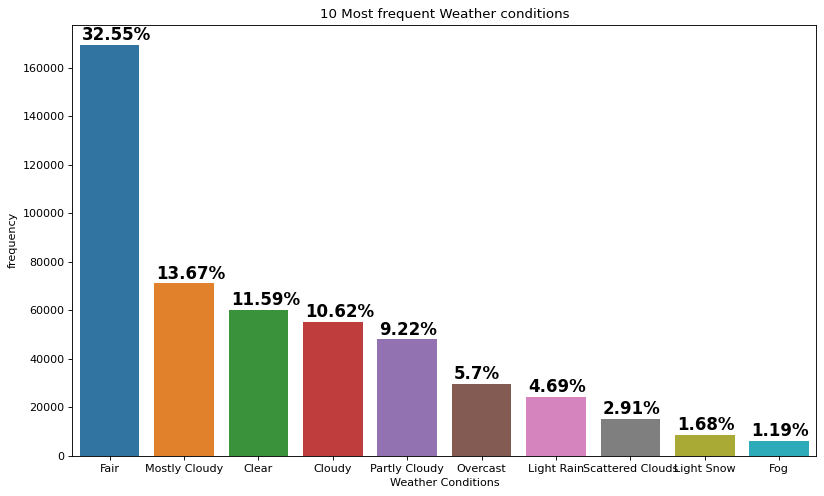

In [ ]:
fig, ax = plt.subplots(figsize = (12,7), dpi = 80)
sns.barplot(x=val_counts.index[:10], y=val_counts.iloc[:10])

total = val_counts.sum()

for i in ax.patches:
    ax.text(i.get_x()+.03, i.get_height()+2000, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15, weight='bold',
                color='black')

plt.title("10 Most frequent Weather conditions")
plt.xlabel("Weather Conditions")
plt.ylabel("frequency")
plt.show()

Weather condition

- Has 106 unqiue categorical values
- Around 10 values cover almost 90% of the samples, rest rarely appear

- Y do we need to process this?
  - Since the data has been pulled from various APIs many diff values might have almost similar interpretation
  - Defining relative order among the values can be very diff inorder to apply label/ordinal encoding
  - one-hot will create a lot of sparse data
- Possible Solution?
  - Retain only the most common values and drop the others
  - Carefully aggregate various values into broad categories

In [ ]:
print("Unique wind directions")
print(df['wind_direction'].unique())

Unique wind directions
['SSE' 'East' 'WNW' 'South' 'SE' 'West' 'NW' 'SSW' 'WSW' 'SW' 'Calm' nan
 'NE' 'ESE' 'NNE' 'Variable' 'NNW' 'ENE' 'North' 'E' 'S' 'CALM' 'VAR' 'N'
 'W']


![Reading wind directions](	https://www.surfertoday.com/images/stories/compassrose.jpg)

Wind Direction
- we have a lot of different unqiue values
- But a few are just duplicates i.e., West and W are the same, North & N are the same similarly, S & South, E & East, CALM & Calm, Variable & VAR

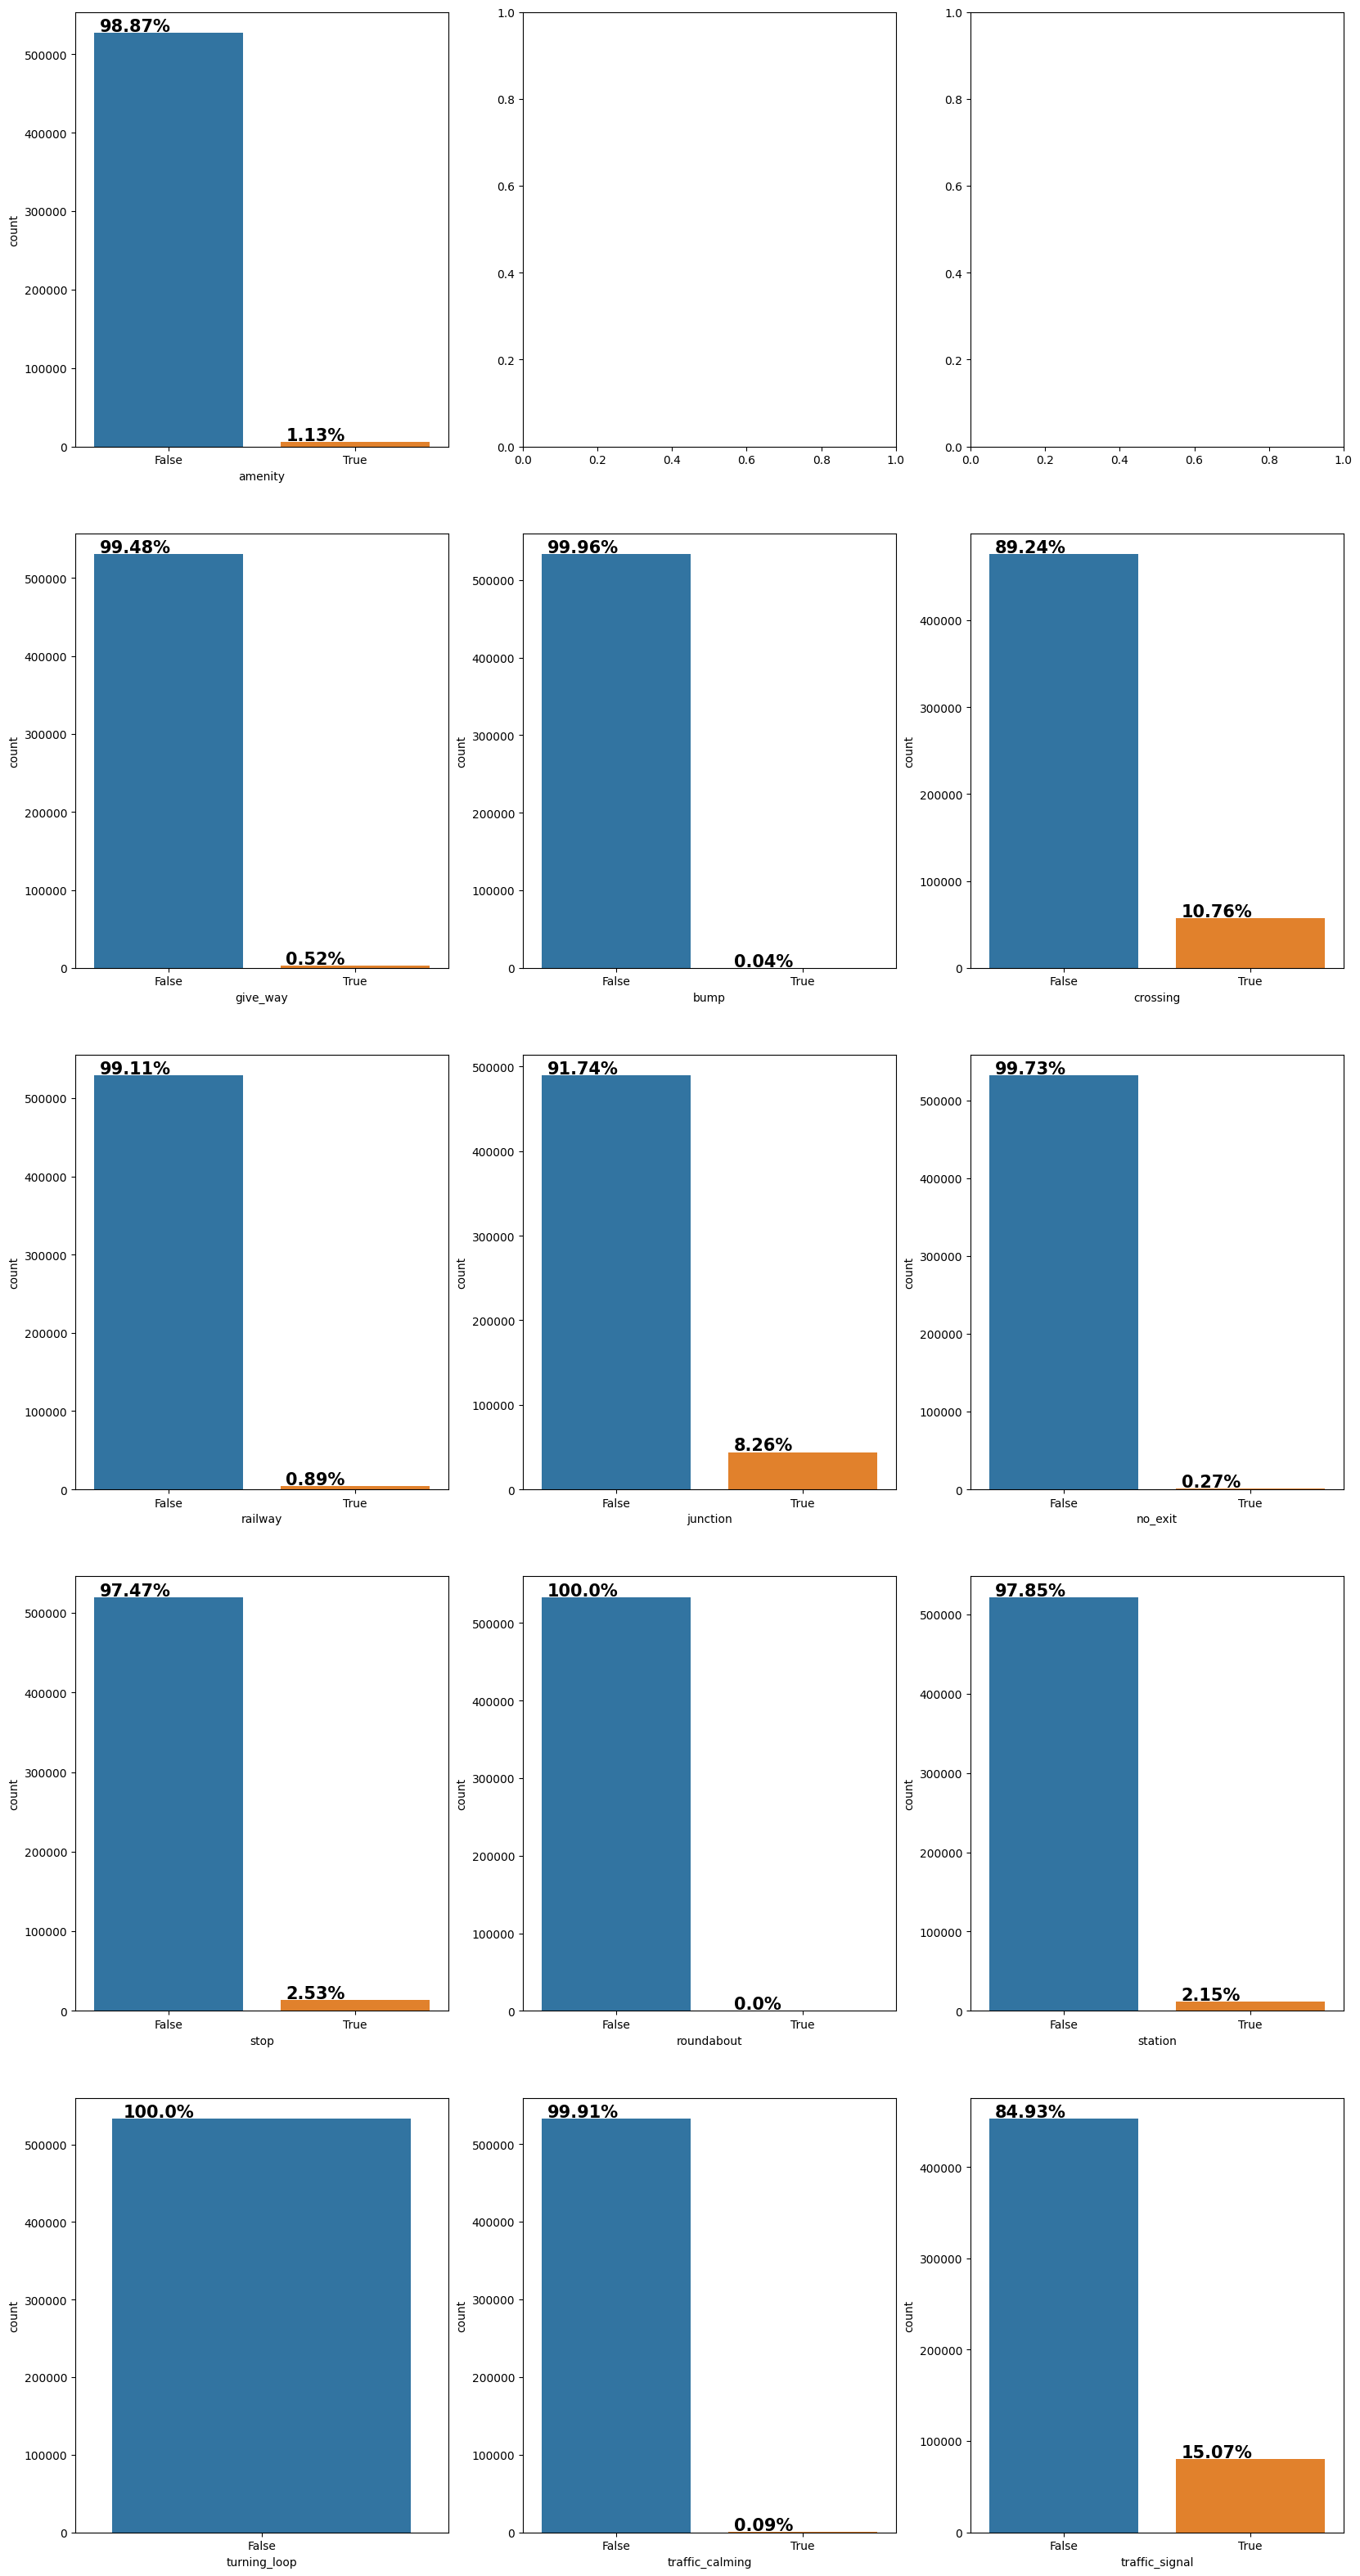

In [ ]:
N_PLOTS_PER_ROW = 3
bool_type_cols = df.select_dtypes('bool').columns
nbool_cols = len(bool_type_cols)
nrows = math.ceil(nbool_cols/N_PLOTS_PER_ROW)

fig, axs = plt.subplots(nrows=nrows, ncols=N_PLOTS_PER_ROW, figsize=(20, 40))

total = df.shape[0]

for i, col in enumerate(bool_type_cols):
    r = math.ceil(i/N_PLOTS_PER_ROW)
    c = i%N_PLOTS_PER_ROW
    axes = axs[r][c]
    sns.countplot(data=df, x = col, ax = axes)

    #writing percentages on each bar
    for p in axes.patches:
        axes.text(p.get_x()+.03, p.get_height()+2000, \
            str(round((p.get_height()/total)*100, 2))+'%', fontsize=15, weight='bold',
                color='black')

plt.show()

All boolean data observation

- False constitutes majority of the data

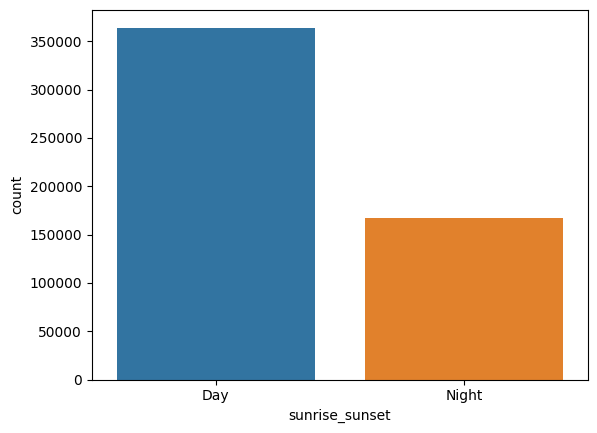

In [ ]:
sns.countplot(data = df, x = 'sunrise_sunset')
plt.show()

**Observation**
- Signals that majority of accidents are happening during the day time

In [ ]:
N_PLOTS_PER_ROW = 3
cont_type_cols = df.select_dtypes('float64').columns
ncont_cols = len(cont_type_cols)
nrows = math.ceil(ncont_cols/N_PLOTS_PER_ROW)

fig, axs = plt.subplots(nrows=nrows, ncols=N_PLOTS_PER_ROW, figsize=(20, 40))

total = df.shape[0]

for i, col in enumerate(cont_type_cols):
    r = math.ceil(i/N_PLOTS_PER_ROW)
    c = i%N_PLOTS_PER_ROW
    axes = axs[r][c]
    sns.boxplot(data=df, y = col, ax = axes)

plt.show()

## Treating a few features

weather_condtions, wind_direction

### 1. Binning Weather Condition Column

In [ ]:
weather_bins = {
    'Clear': ['Clear', 'Fair', 'Fair / Windy'],
    'Foggy/not clear': [
        'Patches of Fog', 'Light Freezing Fog', 'Drizzle and Fog', 'Fog / Windy', 'Smoke / Windy', 'Widespread Dust / Windy',
        'Patches of Fog / Windy', 'Partial Fog', 'Partial Fog / Windy', 'Sand / Dust Whirlwinds / Windy',
        'Blowing Sand', 'Blowing Dust / Windy','Duststorm', 'Sand / Dust Whirls Nearby'
    ],
    'Cloudy': [
        'Cloudy', 'Mostly Cloudy', 'Mostly Cloudy / Windy', 'Partly Cloudy', 'Scattered Clouds', 'Funnel Cloud', 'Sand / Dust Whirlwinds', 'Mist / Windy','Overcast'
    ],
    'Rainy': ['Light Rain', 'Rain', 'Light Freezing Drizzle', 'Light Drizzle', 'Light Freezing Rain', 'Drizzle', 'Light Rain Showers',
              'Showers in the Vicinity', 'Rain / Windy', 'Squalls', 'Thunder', 'Thunder / Windy',
               'Haze / Windy', 'Light Drizzle / Windy', 'Wintry Mix', 'Wintry Mix / Windy', 'Sleet / Windy',
              'Squalls / Windy', 'Light Rain Shower / Windy', 'Snow and Thunder / Windy', 'Light Sleet / Windy',
                'Drizzle / Windy', 'Thunder and Hail', 'Freezing Rain / Windy',
               'Thunder / Wintry Mix / Windy', 'Rain and Sleet', 'Light Hail', 'Light Thunderstorm',
              'Heavy Freezing Drizzle',  'Thunderstorms and Snow', 'Light Rain / Windy',
              'Heavy Rain Showers', 'Rain Shower / Windy', 'Sleet and Thunder', 'Thunder and Hail / Windy',
              'Heavy Sleet / Windy', 'Sand / Windy', 'Freezing Rain / Windy'
             ],
    'Extremes': [
        'Heavy Rain', 'T-Storm', 'Heavy T-Storm', 'Heavy Thunderstorms and Rain', 'Heavy T-Storm / Windy', 'Heavy Thunderstorms and Snow', 'Heavy Rain / Windy', 'tornado',
        'Heavy Ice Pellets', 'T-Storm / Windy', 'Heavy Freezing Rain / Windy', 'Heavy Snow with Thunder', 'Heavy Blowing Snow', 'Shallow Fog / Windy', 'Heavy Sleet and Thunder',
        'Heavy Thunderstorms with Small Hail', 'Hail', 'Heavy Rain Shower / Windy', 'Heavy Rain Shower', 'T-Storm / Windy', 'Heavy Rain Shower / Windy', 'Sleet and Thunder / Windy'
    ],

    'Snowy': [
        'Light Snow', 'Snow', 'Light Snow / Windy', 'Snow Grains', 'Snow Showers', 'Snow / Windy', 'Light Snow and Sleet', 'Snow and Sleet',
        'Light Snow and Sleet / Windy', 'Snow and Sleet / Windy', 'Blowing Snow / Windy','Light Snow and Sleet / Windy','Blowing Snow Nearby',
        'Blowing Snow Nearby', 'Drifting Snow','Light Snow with Thunder', 'Snow and Thunder','Light Blowing Snow','Light Snow Shower / Windy',
        'Light Snow Grains', 'Low Drifting Snow', 'Drifting Snow / Windy'
    ]
}

#changing all the values to lower case
for bin_name, bin_values in weather_bins.items():
  weather_bins[bin_name] = [val.lower() for val in bin_values]

- The above can have a few misclassifications since all the values have been scanned manually to observe a pattern and possible major categories

Following are a few along with pattern

1. Clear: contains clear or fair
2. Cloudy: contains cloud
3. Fog/Not clear: contains fog, sand, dust,smoke
4. Extreme: contains Heavy, Hail, T-Storm, sleet and not light
5. snowy: contains snow
6. Rainy: contains Rain, shower, sleet, thunder, drizzle, drizzling, winter
7. other: unmatched or unknown

In [ ]:
weather_patterns = [
      ('clear', re.compile('fair|clear',re.IGNORECASE)),
      ('cloudy', re.compile('cloud|overcast',re.IGNORECASE)),
      ('fog/notClear', re.compile('fog|sand|dust|smok(e|y)',re.IGNORECASE)),
      ('extreme', re.compile('heavy|heavily|hail|t-storm|tornado', re.IGNORECASE)), # SHOULD NOT CONTAIN word LIGHT
      ('snowy', re.compile('snow', re.IGNORECASE)),
      ('rainy', re.compile(r'rain|drizzl(e|ing)|sleet|thunder|winter|drop|shower', re.IGNORECASE))
]

def weather_mapping(weather):
  for label, pattern in weather_patterns:
    if pattern.search(str(weather)):
      return label
  return "other"

def map_weather_to_bins(weather):
  weather = str(weather).lower()
  for bin_name, bin_values in weather_bins.items():
    if weather in bin_values:
      return bin_name
  return 'Other'

In [ ]:
#USING REGEX Mapping
df['weather_bins_regex'] = df['weather_condition'].apply(weather_mapping)

In [ ]:
# USING MANUAL MAPPING
df['weather_bins_manual'] = df['weather_condition'].apply(map_weather_to_bins)

In [ ]:
df['weather_bins_regex'].value_counts(normalize=True)

clear           0.434684
cloudy          0.416021
rainy           0.070073
other           0.035842
snowy           0.019765
fog/notClear    0.014303
extreme         0.009312
Name: weather_bins_regex, dtype: float64

In [ ]:
df['weather_bins_manual'].value_counts(normalize=True)

Clear              0.434684
Cloudy             0.412572
Rainy              0.065893
Other              0.058038
Snowy              0.019626
Extremes           0.008390
Foggy/not clear    0.000797
Name: weather_bins_manual, dtype: float64

### 2. Mapping duplicate data in Wind Direction column

In [ ]:
print("Unique wind directions")
print(df['wind_direction'].unique())

Unique wind directions
['SSE' 'East' 'WNW' 'South' 'SE' 'West' 'NW' 'SSW' 'WSW' 'SW' 'Calm' nan
 'NE' 'ESE' 'NNE' 'Variable' 'NNW' 'ENE' 'North' 'E' 'S' 'CALM' 'VAR' 'N'
 'W']


In [ ]:
wind_mappings = {
    'south': ['south', 's'],
    'north': ['north', 'n'],
    'east': ['east', 'e'],
    'west': ['west', 'w'],
    'var': ['variable', 'var']
}

def map_wind_dir(wind_dir):
  wind_dir = str(wind_dir).lower()
  for label, vals in wind_mappings.items():
    if wind_dir in vals:
      return label

  return wind_dir

In [ ]:
df['wind_direction_mapped'] = df['wind_direction'].apply(map_wind_dir)

In [ ]:
df['wind_direction_mapped'].unique()

array(['sse', 'east', 'wnw', 'south', 'se', 'west', 'nw', 'ssw', 'wsw',
       'sw', 'calm', 'nan', 'ne', 'ese', 'nne', 'var', 'nnw', 'ene',
       'north'], dtype=object)